In [18]:
# Test the get_peaks function
import sys
import os

# Add the app directory to the path so we can import utils
sys.path.append(os.path.abspath('.'))
from app.utils import get_peaks, process_spectrum, get_spectrum_data

# Choose a material ID to test with
material_id = 'ABS PLAS193'

# Test the get_peaks function
pre_calculated_peaks = get_peaks(material_id)
print(f"Pre-calculated peaks from reference_peaks table for {material_id}:")
for i, (wavenumber, intensity) in enumerate(pre_calculated_peaks[:10], 1):
    print(f"{i}. Wavenumber: {wavenumber}, Intensity: {intensity}")

# Compare with process_spectrum
intensities, wavelengths, _ = get_spectrum_data(material_id)
calculated_peaks = process_spectrum(intensities, wavelengths)
print(f"\nPeaks calculated on-the-fly using process_spectrum for {material_id}:")
for i, (wavenumber, intensity) in enumerate(calculated_peaks[:10], 1):
    print(f"{i}. Wavenumber: {wavenumber}, Intensity: {intensity}")

# Compare counts
print(f"\nNumber of pre-calculated peaks: {len(pre_calculated_peaks)}")
print(f"Number of calculated peaks: {len(calculated_peaks)}")

# Check if the wavenumbers match between the two approaches
pre_calc_wavenumbers = {peak[0] for peak in pre_calculated_peaks}
calc_wavenumbers = {peak[0] for peak in calculated_peaks}
common_wavenumbers = pre_calc_wavenumbers.intersection(calc_wavenumbers)

print(f"\nNumber of matching wavenumbers: {len(common_wavenumbers)}")
print(f"Percentage of matching peaks: {len(common_wavenumbers)/max(len(pre_calc_wavenumbers), len(calc_wavenumbers))*100:.1f}%")

Pre-calculated peaks from reference_peaks table for ABS PLAS193:
1. Wavenumber: 998.0, Intensity: 1.0
2. Wavenumber: 2902.0, Intensity: 0.858586597298905
3. Wavenumber: 3054.0, Intensity: 0.836264287310719
4. Wavenumber: 2859.0, Intensity: 0.497860219358591
5. Wavenumber: 2867.0, Intensity: 0.497160516550153
6. Wavenumber: 2234.0, Intensity: 0.483970985120333
7. Wavenumber: 1600.0, Intensity: 0.404905151641735
8. Wavenumber: 1196.0, Intensity: 0.401864096299497
9. Wavenumber: 1028.0, Intensity: 0.384372515443611
10. Wavenumber: 1191.0, Intensity: 0.348961930602561

Peaks calculated on-the-fly using process_spectrum for ABS PLAS193:
1. Wavenumber: 625.0, Intensity: 0.251591532597052
2. Wavenumber: 998.0, Intensity: 1.0
3. Wavenumber: 1028.0, Intensity: 0.384372515443611
4. Wavenumber: 1153.0, Intensity: 0.284146102347498
5. Wavenumber: 1191.0, Intensity: 0.348961930602561
6. Wavenumber: 1196.0, Intensity: 0.401864096299497
7. Wavenumber: 1449.0, Intensity: 0.278488852792222
8. Wavenumbe

In [19]:
# Examine database structure to understand reference_peaks table
import sqlite3
import os

db_file_path = 'app/database/microplastics_reference.db'

conn = sqlite3.connect(db_file_path)
cursor = conn.cursor()

# Check all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(f"- {table[0]}")

# Check if reference_peaks table exists
reference_peaks_exists = any(table[0] == 'reference_peaks' for table in tables)
print(f"\nDoes reference_peaks table exist? {reference_peaks_exists}")

# If reference_peaks exists, examine its structure
if reference_peaks_exists:
    cursor.execute("PRAGMA table_info(reference_peaks)")
    columns = cursor.fetchall()
    print("\nColumns in reference_peaks table:")
    for col in columns:
        print(f"- {col[1]} ({col[2]})")
    
    # Get sample data from the table
    cursor.execute("SELECT * FROM reference_peaks LIMIT 5")
    rows = cursor.fetchall()
    print(f"\nSample data (first {len(rows)} rows):")
    for row in rows:
        print(row)
else:
    print("\nThe reference_peaks table does not exist. You need to create it first.")
    
    # Let's check the microplastics table structure for reference
    cursor.execute("PRAGMA table_info(microplastics)")
    columns = cursor.fetchall()
    print("\nColumns in microplastics table:")
    for col in columns:
        print(f"- {col[1]} ({col[2]})")

conn.close()

Tables in the database:
- microplastics
- sample_bank
- sqlite_sequence
- reference_peaks

Does reference_peaks table exist? True

Columns in reference_peaks table:
- id (INTEGER)
- microplastic_id (INTEGER)
- peak_rank (INTEGER)
- wavenumber (REAL)
- intensity (REAL)

Sample data (first 5 rows):
(1, 'ABS PLAS193', 1, 998.0, 1.0)
(2, 'ABS PLAS193', 2, 2902.0, 0.858586597298905)
(3, 'ABS PLAS193', 3, 3054.0, 0.836264287310719)
(4, 'ABS PLAS193', 4, 2859.0, 0.497860219358591)
(5, 'ABS PLAS193', 5, 2867.0, 0.497160516550153)


In [20]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
# import plotly.express as px
import os
import warnings

# Local server SQL database
import sqlite3 as sq

# Setting of Large numbers format
pd.options.display.float_format = '{:,.2f}'.format

# Set data frame display max 10 rows
pd.set_option('display.max_rows', 10)

# Warning is suppressed
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
# Connect to the SQLite database
db_path = os.path.join('app', 'database', 'microplastics_reference.db')
conn = sq.connect(db_path)
cursor = conn.cursor()

print(f"Successfully connected to database: {db_path}")

Successfully connected to database: app\database\microplastics_reference.db


# SQLite Database Exploration Tutorial

This tutorial will guide you through exploring the `microplastics_reference.db` SQLite database. We'll cover:

1. How to connect to an SQLite database
2. How to list all tables in the database
3. How to view table structure
4. How to query data from tables
5. How to visualize database content
6. How to perform basic SQL operations

## 1. Listing All Tables in the Database

To explore a database, first we need to know what tables it contains. In SQLite, you can use the following query to list all tables:

In [22]:
# Get list of all tables in the database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tables in the database:")
for table in tables:
    print(f"- {table[0]}")

Tables in the database:
- microplastics
- sample_bank
- sqlite_sequence
- reference_peaks


## 2. Exploring Table Structure

Once we know what tables exist in our database, we can examine their structure to understand what columns each table has. In SQLite, we can use the `PRAGMA table_info` command to get this information.

In [23]:
# Function to get table structure
def get_table_info(table_name):
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    # Create a DataFrame to display the table structure in a nice format
    table_info = pd.DataFrame(columns, 
                             columns=['cid', 'name', 'type', 'notnull', 'default_value', 'pk'])
    return table_info

# Let's examine the structure of each table
for table in tables:
    table_name = table[0]
    print(f"\nStructure of table '{table_name}':")
    table_info = get_table_info(table_name)
    display(table_info)


Structure of table 'microplastics':


,cid,name,type,notnull,default_value,pk
0,0,ID,TEXT,0,None,0
1,1,Intensity,REAL,0,None,0
2,2,WaveNumber,REAL,0,None,0
3,3,Comment,TEXT,0,None,0
4,4,Picture,BLOB,0,None,0



Structure of table 'sample_bank':


,cid,name,type,notnull,default_value,pk
0,0,sample_id,TEXT,0,None,0
1,1,intensity,REAL,0,None,0
2,2,wave_number,REAL,0,None,0
3,3,Comment,TEXT,0,None,0
4,4,comparison_results,TEXT,0,None,0
5,5,best_match,TEXT,0,None,0
6,6,similarity_score,TEXT,0,None,0



Structure of table 'sqlite_sequence':


,cid,name,type,notnull,default_value,pk
0,0,name,,0,None,0
1,1,seq,,0,None,0



Structure of table 'reference_peaks':


,cid,name,type,notnull,default_value,pk
0,0,id,INTEGER,0,None,1
1,1,microplastic_id,INTEGER,0,None,0
2,2,peak_rank,INTEGER,0,None,0
3,3,wavenumber,REAL,0,None,0
4,4,intensity,REAL,0,None,0


## 3. Viewing Table Data

Now that we know the structure of our tables, let's view some actual data to better understand what's stored in each table.

In [24]:
# Function to preview the first few rows of a table
def preview_table(table_name, limit=3400):
    query = f"SELECT * FROM {table_name} LIMIT {limit}"
    return pd.read_sql_query(query, conn)

# Preview each table
for table in tables:
    table_name = table[0]
    print(f"\nPreview of table '{table_name}':")
    try:
        preview_df = preview_table(table_name)
        display(preview_df)
        
        # Get row count
        cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
        row_count = cursor.fetchone()[0]
        print(f"Total rows in {table_name}: {row_count}")
    except Exception as e:
        print(f"Error previewing {table_name}: {e}")


Preview of table 'microplastics':


,ID,Intensity,WaveNumber,Comment,Picture
0,ABS PLAS193,0.10,200.00,Test comment ABS PLAS193,None
1,ABS PLAS193,0.10,201.00,Test comment ABS PLAS193,None
2,ABS PLAS193,0.10,202.00,Test comment ABS PLAS193,None
3,ABS PLAS193,0.10,203.00,Test comment ABS PLAS193,None
4,ABS PLAS193,0.10,204.00,Test comment ABS PLAS193,None
...,...,...,...,...,...
3395,beachcast white foam sheet PLAS251,0.04,394.00,None,None
3396,beachcast white foam sheet PLAS251,0.04,395.00,None,None
3397,beachcast white foam sheet PLAS251,0.04,396.00,None,None
3398,beachcast white foam sheet PLAS251,0.05,397.00,None,None


Total rows in microplastics: 539751

Preview of table 'sample_bank':


,sample_id,intensity,wave_number,Comment,comparison_results,best_match,similarity_score
0,PP,0.07,233.38,None,None,chitin BIOL022,chitin BIOL022
1,PP,0.08,238.70,None,None,chitin BIOL022,chitin BIOL022
2,PP,0.04,244.01,None,None,chitin BIOL022,chitin BIOL022
3,PP,0.00,249.31,None,None,chitin BIOL022,chitin BIOL022
4,PP,0.04,254.61,None,None,chitin BIOL022,chitin BIOL022
...,...,...,...,...,...,...,...
3395,S2_preprocessed3,-0.02,"2,033.82",None,None,Polyvinyl Chloride 6. Red Cable Cover,Polyvinyl Chloride 6. Red Cable Cover
3396,S2_preprocessed3,0.02,"2,037.71",None,None,Polyvinyl Chloride 6. Red Cable Cover,Polyvinyl Chloride 6. Red Cable Cover
3397,S2_preprocessed3,-0.01,"2,041.61",None,None,Polyvinyl Chloride 6. Red Cable Cover,Polyvinyl Chloride 6. Red Cable Cover
3398,S2_preprocessed3,-0.00,"2,045.50",None,None,Polyvinyl Chloride 6. Red Cable Cover,Polyvinyl Chloride 6. Red Cable Cover


Total rows in sample_bank: 8400

Preview of table 'sqlite_sequence':


,name,seq
0,reference_peaks,2597


Total rows in sqlite_sequence: 1

Preview of table 'reference_peaks':


,id,microplastic_id,peak_rank,wavenumber,intensity
0,1,ABS PLAS193,1,998.00,1.00
1,2,ABS PLAS193,2,"2,902.00",0.86
2,3,ABS PLAS193,3,"3,054.00",0.84
3,4,ABS PLAS193,4,"2,859.00",0.50
4,5,ABS PLAS193,5,"2,867.00",0.50
...,...,...,...,...,...
2592,2593,Polystyrene 3. Blue Fragment,1,"1,527.36",1.00
2593,2594,Polystyrene 3. Blue Fragment,2,"1,339.00",0.50
2594,2595,Polystyrene 3. Blue Fragment,3,"1,449.89",0.49
2595,2596,Polystyrene 3. Blue Fragment,4,"1,002.08",0.37


Total rows in reference_peaks: 2597


## 4. Visualizing Database Content

Now let's create some visualizations to better understand the data. We'll try to create appropriate visualizations based on the content of each table.


Visualization for 'microplastics':


<Figure size 1200x600 with 0 Axes>


Visualization for 'sample_bank':


<Figure size 1200x600 with 0 Axes>


Visualization for 'sqlite_sequence':


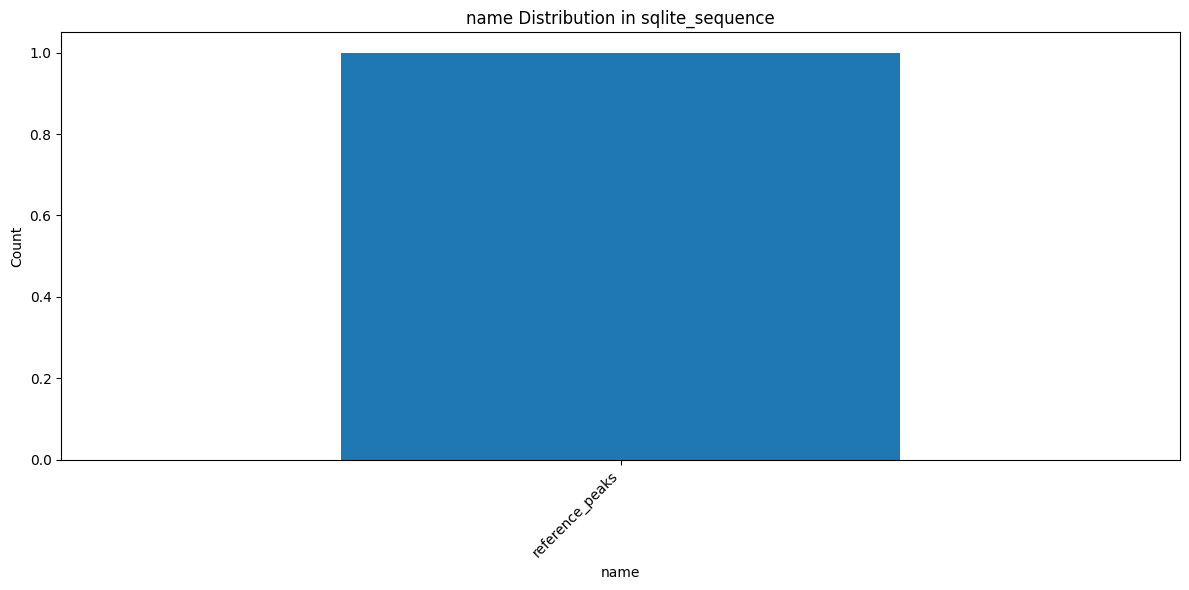


Visualization for 'reference_peaks':


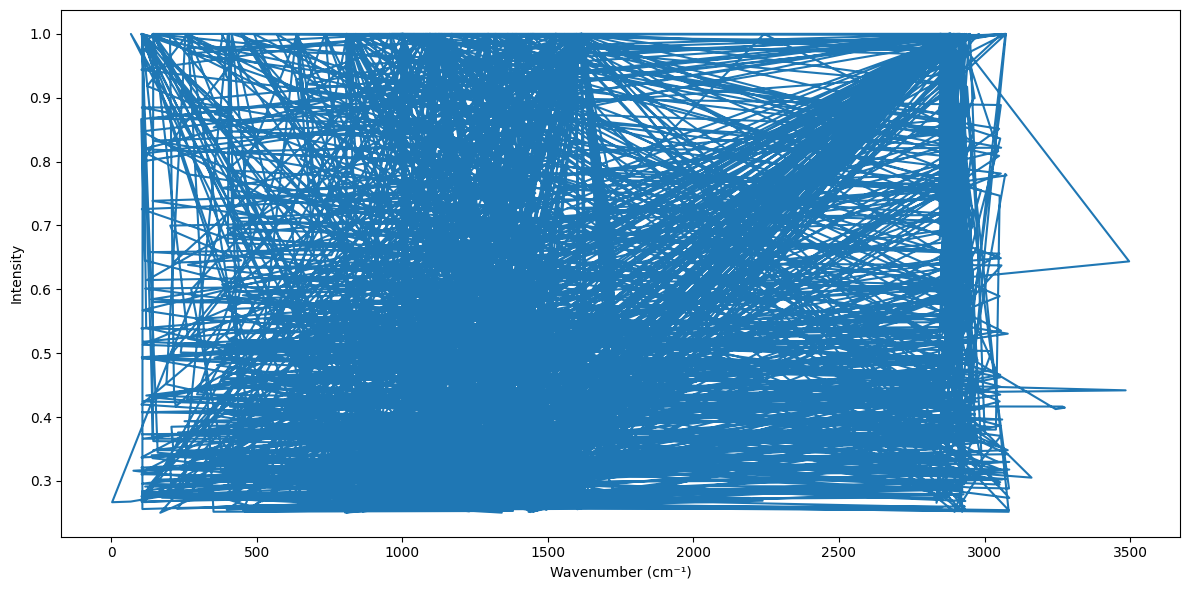

In [25]:
# Uncomment this to use plotly for interactive charts
# import plotly.express as px
# import plotly.graph_objects as go

# Function to create visualizations based on table content
def visualize_table(table_name):
    # Get all data from the table
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    if len(df) == 0:
        print(f"Table {table_name} is empty. No visualization possible.")
        return
    
    # Set up the figure
    plt.figure(figsize=(12, 6))
    
    # Case 1: If we have spectral data (assuming it has wavelength/intensity columns)
    if any(col.lower() in ['wavelength', 'wavenumber', 'intensity', 'raman_shift'] for col in df.columns):
        # If it looks like spectral data, plot spectra
        if 'wavelength' in df.columns and 'intensity' in df.columns:
            plt.plot(df['wavelength'], df['intensity'])
            plt.xlabel('Wavelength')
            plt.ylabel('Intensity')
        elif 'wavenumber' in df.columns and 'intensity' in df.columns:
            plt.plot(df['wavenumber'], df['intensity'])
            plt.xlabel('Wavenumber (cm⁻¹)')
            plt.ylabel('Intensity')            
        elif 'raman_shift' in df.columns and any('intensity' in col.lower() for col in df.columns):
            # Find the intensity column
            intensity_col = next(col for col in df.columns if 'intensity' in col.lower())
            plt.plot(df['raman_shift'], df[intensity_col])
            plt.xlabel('Raman Shift (cm⁻¹)')
            plt.ylabel('Intensity')
    
    # Case 2: If we have categorical data, make a bar chart
    elif df.select_dtypes(include=['object', 'category']).shape[1] > 0:
        categorical_col = df.select_dtypes(include=['object', 'category']).columns[0]
        value_counts = df[categorical_col].value_counts()
        
        # Limit to top 20 categories if there are many
        if len(value_counts) > 20:
            value_counts = value_counts.head(20)
            plt.title(f"Top 20 {categorical_col} in {table_name}")
        else:
            plt.title(f"{categorical_col} Distribution in {table_name}")
            
        value_counts.plot(kind='bar')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        
    # Case 3: If we have numerical data, make a histogram
    elif df.select_dtypes(include=['int64', 'float64']).shape[1] > 0:
        numerical_col = df.select_dtypes(include=['int64', 'float64']).columns[0]
        plt.hist(df[numerical_col], bins=20, edgecolor='black')
        plt.title(f"Distribution of {numerical_col} in {table_name}")
        plt.xlabel(numerical_col)
        plt.ylabel('Frequency')
    
    # Case 4: Default case if we can't determine appropriate visualization
    else:
        plt.text(0.5, 0.5, f"No appropriate visualization for {table_name}",
                 horizontalalignment='center', verticalalignment='center', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# Visualize each table
for table in tables:
    table_name = table[0]
    print(f"\nVisualization for '{table_name}':")
    try:
        visualize_table(table_name)
    except Exception as e:
        print(f"Error visualizing {table_name}: {e}")

## 5. SQL Tutorial for Beginners

Now let's learn how to write basic SQL queries to interact with the database. We'll start with simple queries and build up to more complex ones.

### Basic SQL Operations

1. **SELECT**: Used to retrieve data from a table
2. **WHERE**: Used to filter records based on conditions
3. **ORDER BY**: Used to sort records
4. **LIMIT**: Used to restrict the number of records returned
5. **JOIN**: Used to combine rows from two or more tables

Let's try these operations with our database.

In [26]:
# Example 1: Basic SELECT query
# Select all rows from the first table we found (adjust as needed)
if tables:  # Only proceed if we have tables
    first_table = tables[0][0]
    query = f"SELECT * FROM {first_table} LIMIT 10"
    result_df = pd.read_sql_query(query, conn)
    
    print(f"Example 1: SELECT * FROM {first_table} LIMIT 10")
    display(result_df)
    
    # Get column names for next examples
    columns = list(result_df.columns)
    
    if len(columns) >= 2:  # Only proceed if we have at least 2 columns for demonstration
        # Example 2: SELECT specific columns
        query = f"SELECT {columns[0]}, {columns[1]} FROM {first_table} LIMIT 5"
        result_df = pd.read_sql_query(query, conn)
        
        print(f"\nExample 2: SELECT {columns[0]}, {columns[1]} FROM {first_table} LIMIT 5")
        display(result_df)
        
        # Example 3: SELECT with ORDER BY
        query = f"SELECT {columns[0]}, {columns[1]} FROM {first_table} ORDER BY {columns[0]} LIMIT 5"
        result_df = pd.read_sql_query(query, conn)
        
        print(f"\nExample 3: SELECT with ORDER BY")
        print(f"SQL: SELECT {columns[0]}, {columns[1]} FROM {first_table} ORDER BY {columns[0]} LIMIT 5")
        display(result_df)
        
        # Try to find a numeric column for WHERE clause example
        numeric_col = None
        for col in columns:
            try:
                # Check if the column contains numeric data
                pd.to_numeric(result_df[col])
                numeric_col = col
                break
            except:
                continue
        
        if numeric_col:
            # Example 4: SELECT with WHERE clause
            query = f"SELECT * FROM {first_table} WHERE {numeric_col} > 0 LIMIT 5"
            result_df = pd.read_sql_query(query, conn)
            
            print(f"\nExample 4: SELECT with WHERE clause")
            print(f"SQL: SELECT * FROM {first_table} WHERE {numeric_col} > 0 LIMIT 5")
            display(result_df)
else:
    print("No tables found in the database for SQL examples.")

Example 1: SELECT * FROM microplastics LIMIT 10


,ID,Intensity,WaveNumber,Comment,Picture
0,ABS PLAS193,0.10,200.00,Test comment ABS PLAS193,None
1,ABS PLAS193,0.10,201.00,Test comment ABS PLAS193,None
2,ABS PLAS193,0.10,202.00,Test comment ABS PLAS193,None
3,ABS PLAS193,0.10,203.00,Test comment ABS PLAS193,None
4,ABS PLAS193,0.10,204.00,Test comment ABS PLAS193,None
5,ABS PLAS193,0.10,205.00,Test comment ABS PLAS193,None
6,ABS PLAS193,0.11,206.00,Test comment ABS PLAS193,None
7,ABS PLAS193,0.11,207.00,Test comment ABS PLAS193,None
8,ABS PLAS193,0.11,208.00,Test comment ABS PLAS193,None
9,ABS PLAS193,0.11,209.00,Test comment ABS PLAS193,None



Example 2: SELECT ID, Intensity FROM microplastics LIMIT 5


,ID,Intensity
0,ABS PLAS193,0.10
1,ABS PLAS193,0.10
2,ABS PLAS193,0.10
3,ABS PLAS193,0.10
4,ABS PLAS193,0.10



Example 3: SELECT with ORDER BY
SQL: SELECT ID, Intensity FROM microplastics ORDER BY ID LIMIT 5


,ID,Intensity
0,ABS PLAS193,0.10
1,ABS PLAS193,0.10
2,ABS PLAS193,0.10
3,ABS PLAS193,0.10
4,ABS PLAS193,0.10



Example 4: SELECT with WHERE clause
SQL: SELECT * FROM microplastics WHERE Intensity > 0 LIMIT 5


,ID,Intensity,WaveNumber,Comment,Picture
0,ABS PLAS193,0.10,200.00,Test comment ABS PLAS193,None
1,ABS PLAS193,0.10,201.00,Test comment ABS PLAS193,None
2,ABS PLAS193,0.10,202.00,Test comment ABS PLAS193,None
3,ABS PLAS193,0.10,203.00,Test comment ABS PLAS193,None
4,ABS PLAS193,0.10,204.00,Test comment ABS PLAS193,None


In [27]:
# Example 5: JOIN operation (if we have multiple tables with related data)
if len(tables) >= 2:  # Only proceed if we have at least 2 tables
    table1 = tables[0][0]
    table2 = tables[1][0]
    
    # Get columns from both tables to find potential join columns
    cols1 = [col[1] for col in cursor.execute(f"PRAGMA table_info({table1})").fetchall()]
    cols2 = [col[1] for col in cursor.execute(f"PRAGMA table_info({table2})").fetchall()]
    
    # Look for common column names (potential join keys)
    common_cols = set(cols1).intersection(set(cols2))
    
    if common_cols:  # If we found potential join columns
        join_col = list(common_cols)[0]
        query = f"""
        SELECT t1.*, t2.*
        FROM {table1} t1
        JOIN {table2} t2 ON t1.{join_col} = t2.{join_col}
        LIMIT 5
        """
        
        try:
            result_df = pd.read_sql_query(query, conn)
            print(f"\nExample 5: JOIN operation")
            print(f"SQL: SELECT t1.*, t2.* FROM {table1} t1 JOIN {table2} t2 ON t1.{join_col} = t2.{join_col} LIMIT 5")
            display(result_df)
        except Exception as e:
            print(f"\nCouldn't perform JOIN example: {e}")
            print("JOIN operations require tables with related columns.")
    else:
        print("\nNo common columns found between tables for JOIN example.")


Example 5: JOIN operation
SQL: SELECT t1.*, t2.* FROM microplastics t1 JOIN sample_bank t2 ON t1.Comment = t2.Comment LIMIT 5


,ID,Intensity,WaveNumber,Comment,Picture,sample_id,intensity,wave_number,Comment,comparison_results,best_match,similarity_score


## 6. Understanding SQL Queries

Let's break down the basic SQL syntax for beginners:

### SELECT Statement

```sql
SELECT column1, column2, ... 
FROM table_name
WHERE condition
ORDER BY column1 [ASC|DESC]
LIMIT number;
```

- **SELECT**: Specifies which columns you want to retrieve
- **FROM**: Specifies which table to query
- **WHERE**: Filters records based on a condition
- **ORDER BY**: Sorts the result
- **LIMIT**: Restricts how many rows are returned

### Common WHERE Conditions

- Equal: `=`
- Not Equal: `<>` or `!=`
- Greater Than: `>`
- Less Than: `<`
- Greater Than or Equal: `>=`
- Less Than or Equal: `<=`
- BETWEEN: `BETWEEN value1 AND value2`
- LIKE: `LIKE pattern` (use with wildcards like `%`)
- IN: `IN (value1, value2, ...)`

### JOIN Operations

JOINs are used to combine rows from two or more tables based on a related column.

```sql
SELECT column1, column2, ...
FROM table1
JOIN table2 ON table1.common_column = table2.common_column;
```

Types of JOINs:
- INNER JOIN: Returns records with matching values in both tables
- LEFT JOIN: Returns all records from the left table and matched records from the right
- RIGHT JOIN: Returns all records from the right table and matched records from the left
- FULL JOIN: Returns all records when there's a match in either table

## 7. Practical Examples with the Microplastics Database

Now let's apply what we've learned to create some practical queries specific to our microplastics_reference database.


Searching for records in microplastics
SQL: SELECT * FROM microplastics WHERE ID LIKE '%a%' LIMIT 10


,ID,Intensity,WaveNumber,Comment,Picture
0,ABS PLAS193,0.10,200.00,Test comment ABS PLAS193,None
1,ABS PLAS193,0.10,201.00,Test comment ABS PLAS193,None
2,ABS PLAS193,0.10,202.00,Test comment ABS PLAS193,None
3,ABS PLAS193,0.10,203.00,Test comment ABS PLAS193,None
4,ABS PLAS193,0.10,204.00,Test comment ABS PLAS193,None
5,ABS PLAS193,0.10,205.00,Test comment ABS PLAS193,None
6,ABS PLAS193,0.11,206.00,Test comment ABS PLAS193,None
7,ABS PLAS193,0.11,207.00,Test comment ABS PLAS193,None
8,ABS PLAS193,0.11,208.00,Test comment ABS PLAS193,None
9,ABS PLAS193,0.11,209.00,Test comment ABS PLAS193,None



Counting records by category in microplastics
SQL: SELECT ID, COUNT(*) as count FROM microplastics GROUP BY ID ORDER BY count DESC


,ID,count
0,white and gray mask filter PLAS252,3201
1,strawberry container PLAS241,3201
2,strapping tape blue PLAS244,3201
3,nylon PLAS190,3201
4,myofibrillar protein BIOL015,3201
...,...,...
334,Polypropylene 18. Purple Foam,727
335,Polypropylene 15. Green Fiber,727
336,Acrylic 2. Pink Fiber Bundle (Polyacrylonitrile),717
337,Dyed Cellulose 5. Red Fiber,710


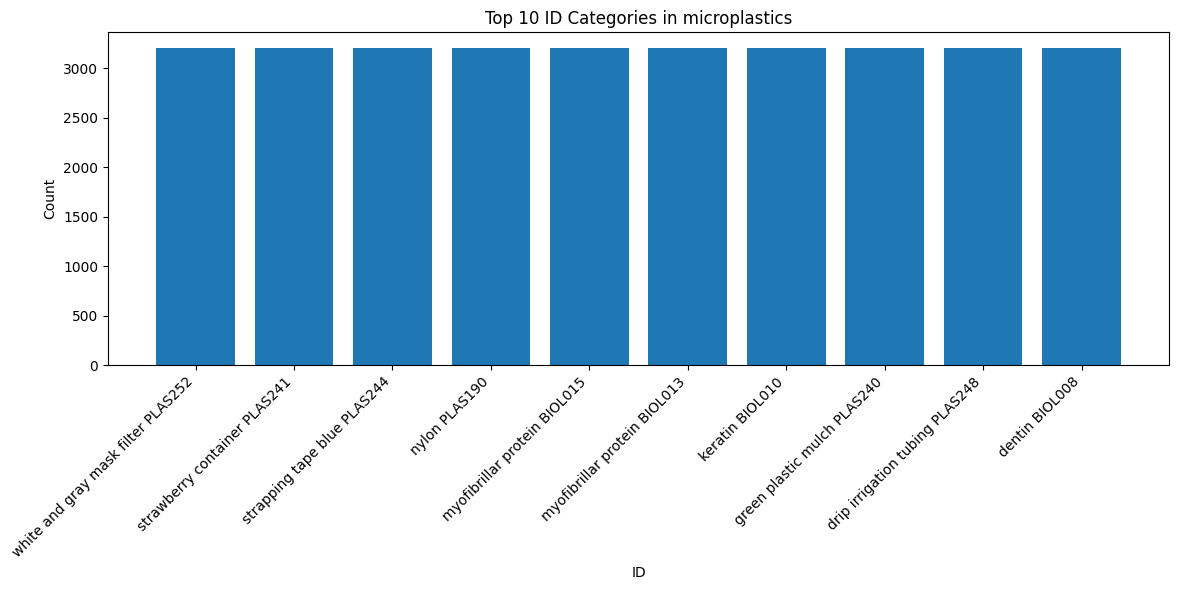

In [28]:
# Let's create some practical examples based on the tables we found

# Example 1: Find specific records in the database
def find_records(table_name, search_column, search_term):
    query = f"SELECT * FROM {table_name} WHERE {search_column} LIKE '%{search_term}%' LIMIT 10"
    result = pd.read_sql_query(query, conn)
    return result

# Example 2: Count records by category
def count_by_category(table_name, category_column):
    query = f"SELECT {category_column}, COUNT(*) as count FROM {table_name} GROUP BY {category_column} ORDER BY count DESC"
    result = pd.read_sql_query(query, conn)
    return result

# Let's run these on the actual tables we have
if tables:
    # Get the first table
    first_table = tables[0][0]
    columns = [col[1] for col in cursor.execute(f"PRAGMA table_info({first_table})").fetchall()]
    
    # Try to find a text column for searching
    text_columns = []
    for col in columns:
        try:
            # Check if this column appears to be text
            query = f"SELECT TYPEOF({col}) FROM {first_table} LIMIT 1"
            result = cursor.execute(query).fetchone()
            if result and result[0] == 'text':
                text_columns.append(col)
        except:
            continue
    
    if text_columns:
        search_col = text_columns[0]  # Use the first text column found
        print(f"\nSearching for records in {first_table}")
        print(f"SQL: SELECT * FROM {first_table} WHERE {search_col} LIKE '%a%' LIMIT 10")
        result = find_records(first_table, search_col, 'a')  # Search for any record containing 'a'
        display(result)
        
        # Try grouping if we have enough records
        try:
            print(f"\nCounting records by category in {first_table}")
            print(f"SQL: SELECT {search_col}, COUNT(*) as count FROM {first_table} GROUP BY {search_col} ORDER BY count DESC")
            result = count_by_category(first_table, search_col)
            display(result)
            
            # Create a bar chart for the category counts
            plt.figure(figsize=(12, 6))
            
            # Limit to top 10 categories if there are many
            if len(result) > 10:
                result = result.head(10)
                plt.title(f"Top 10 {search_col} Categories in {first_table}")
            else:
                plt.title(f"{search_col} Categories in {first_table}")
                
            plt.bar(result[search_col], result['count'])
            plt.xlabel(search_col)
            plt.ylabel('Count')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Couldn't group by category: {e}")

## 8. Conclusion

In this tutorial, we've learned how to:

1. Connect to an SQLite database
2. Explore the tables and their structure
3. View data in the tables
4. Create visualizations of the data
5. Write basic SQL queries
6. Apply SQL knowledge to our specific microplastics database

You can now use these skills to further explore the database and extract meaningful information from it.

### Additional Resources for Learning SQL

- [SQLite Documentation](https://www.sqlite.org/docs.html)
- [W3Schools SQL Tutorial](https://www.w3schools.com/sql/)
- [SQLite with Python Documentation](https://docs.python.org/3/library/sqlite3.html)
- [Pandas SQL Query Reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql_query.html)

## 9. Creating a Reference Peaks Table

Now let's create a new table called `reference_peaks` that will store the 12 highest peaks for each microplastic ID. This will be useful for comparing spectra and identifying unknown samples based on their characteristic peaks.

In [29]:
# Connect to the database again if needed
db_path = os.path.join('app', 'database', 'microplastics_reference.db')
conn = sq.connect(db_path)
cursor = conn.cursor()

# First, check if the reference_peaks table already exists and drop it if it does
cursor.execute("DROP TABLE IF EXISTS reference_peaks")

# Create a new table to store the peaks
cursor.execute("""
CREATE TABLE reference_peaks (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    microplastic_id INTEGER,
    peak_rank INTEGER,           -- 1 to 12, with 1 being the highest intensity
    wavenumber REAL,             -- Raman shift value of the peak
    intensity REAL,              -- Intensity value of the peak
    FOREIGN KEY (microplastic_id) REFERENCES microplastics(id)
)
""")

print("Successfully created reference_peaks table")


Successfully created reference_peaks table


In [30]:
from scipy.signal import find_peaks
import numpy as np
import pandas as pd

# Function to find the top N peaks in a spectrum
def find_top_peaks(raman_shift, intensity, n_peaks=20, height_threshold=0.25):
    """
    Find the top N peaks in a spectrum using scipy.signal.find_peaks.
    
    Args:
        raman_shift: Array of Raman shift values (wavenumbers)
        intensity: Array of intensity values
        n_peaks: Number of top peaks to return (default: 20)
        height_threshold: Minimum height threshold for peak detection (default: 0.25)
    
    Returns:
        DataFrame containing the top N peaks with columns: raman_shift, intensity
        Sorted by intensity in descending order
    """
    # Convert to numpy arrays for scipy processing
    raman_array = np.array(raman_shift)
    intensity_array = np.array(intensity)
    
    # Use scipy.signal.find_peaks to detect peaks
    # This is more robust than manual local maxima detection
    peak_indices, _ = find_peaks(intensity_array, height=height_threshold)
    
    # Extract peak positions and intensities
    peak_wavenumbers = raman_array[peak_indices]
    peak_intensities = intensity_array[peak_indices]
    
    # Create a DataFrame for easier manipulation
    peaks_df = pd.DataFrame({
        'raman_shift': peak_wavenumbers,
        'intensity': peak_intensities
    })
    
    # Sort by intensity in descending order and take top N peaks
    top_peaks = peaks_df.sort_values('intensity', ascending=False).head(n_peaks)
    
    return top_peaks

height_threshold = 0.25  # Set a threshold for peak height
peaks, _ = find_peaks(intensities, height=height_threshold)
peak_wavelengths = [wavelengths[i] for i in peaks]
peak_intensities = [intensities[i] for i in peaks]
# Find the table that contains microplastics spectra
microplastics_table = None
for table in tables:
    # Look for a table that might contain microplastic spectra
    if 'microplastics' in table[0].lower():
        microplastics_table = table[0]
        break

if microplastics_table is None:
    # If no specific table was found, use the first table
    if tables:
        microplastics_table = tables[0][0]
        print(f"No specific microplastics table found, using first table: {microplastics_table}")
    else:
        print("No tables found in the database.")
else:
    print(f"Found potential microplastics table: {microplastics_table}")


Found potential microplastics table: microplastics


In [31]:

if microplastics_table:
    # Check if this table has the necessary columns for spectra
    table_info = get_table_info(microplastics_table)
    columns = table_info['name'].tolist()
    
    # Check if the table has a raman_shift column and an intensity column
    raman_col = next((col for col in columns if 'raman' in col.lower() or 'shift' in col.lower() or 'wave' in col.lower()), None)
    intensity_col = next((col for col in columns if 'intensity' in col.lower()), None)
    id_col = next((col for col in columns if col.lower() == 'id'), 'id')
    
    if raman_col and intensity_col:
        print(f"Found relevant columns: {id_col} (ID), {raman_col} (Raman shift), {intensity_col} (Intensity)")
        
        # Get unique IDs from the microplastics table
        query = f"SELECT DISTINCT {id_col} FROM {microplastics_table}"
        unique_ids = pd.read_sql_query(query, conn)[id_col].tolist()
        
        print(f"Found {len(unique_ids)} unique microplastic IDs")
        
        # Process each microplastic ID
        peaks_added = 0
        for mp_id in unique_ids:
            try:
                # Get the spectrum for this ID - Use proper quotes for string values
                # Check if the ID is numeric or string
                if isinstance(mp_id, (int, float)):
                    query = f"SELECT {raman_col}, {intensity_col} FROM {microplastics_table} WHERE {id_col} = {mp_id}"
                else:
                    # For string IDs, use quotes
                    query = f"SELECT {raman_col}, {intensity_col} FROM {microplastics_table} WHERE {id_col} = '{mp_id}'"
                
                spectrum = pd.read_sql_query(query, conn)
                
                if not spectrum.empty:
                    # Find the top 12 peaks
                    top_peaks = find_top_peaks(spectrum[raman_col], spectrum[intensity_col], n_peaks=12)
                    
                    # Insert each peak into the reference_peaks table
                    for rank, (idx, peak) in enumerate(top_peaks.iterrows(), 1):
                        cursor.execute("""
                        INSERT INTO reference_peaks (microplastic_id, peak_rank, wavenumber, intensity)
                        VALUES (?, ?, ?, ?)
                        """, (mp_id, rank, peak['raman_shift'], peak['intensity']))
                        peaks_added += 1
            except Exception as e:
                print(f"Error processing ID {mp_id}: {e}")
                continue
        # Commit the changes
        conn.commit()
        print(f"Successfully added {peaks_added} peaks to reference_peaks table")
        
        # Preview the new table
        print("\nPreview of reference_peaks table:")
        reference_peaks_preview = pd.read_sql_query("SELECT * FROM reference_peaks LIMIT 20", conn)
        display(reference_peaks_preview)
        
    else:
        print(f"Could not find necessary columns in {microplastics_table}")
        print(f"Need columns for Raman shift and Intensity. Found: {columns}")

Found relevant columns: ID (ID), WaveNumber (Raman shift), Intensity (Intensity)
Found 339 unique microplastic IDs
Successfully added 2597 peaks to reference_peaks table

Preview of reference_peaks table:
Successfully added 2597 peaks to reference_peaks table

Preview of reference_peaks table:


,id,microplastic_id,peak_rank,wavenumber,intensity
0,1,ABS PLAS193,1,998.00,1.00
1,2,ABS PLAS193,2,"2,902.00",0.86
2,3,ABS PLAS193,3,"3,054.00",0.84
3,4,ABS PLAS193,4,"2,859.00",0.50
4,5,ABS PLAS193,5,"2,867.00",0.50
...,...,...,...,...,...
15,16,beachcast white foam sheet PLAS251,4,"1,033.00",0.33
16,17,beachcast white foam sheet PLAS251,5,"2,901.00",0.29
17,18,beachcast white foam sheet PLAS251,6,"1,201.00",0.28
18,19,blue fragment PLAS253,1,"2,880.00",1.00


### Visualizing the Peak Data

Let's visualize the peaks we've identified for a few example microplastics to verify that our peak detection is working correctly.

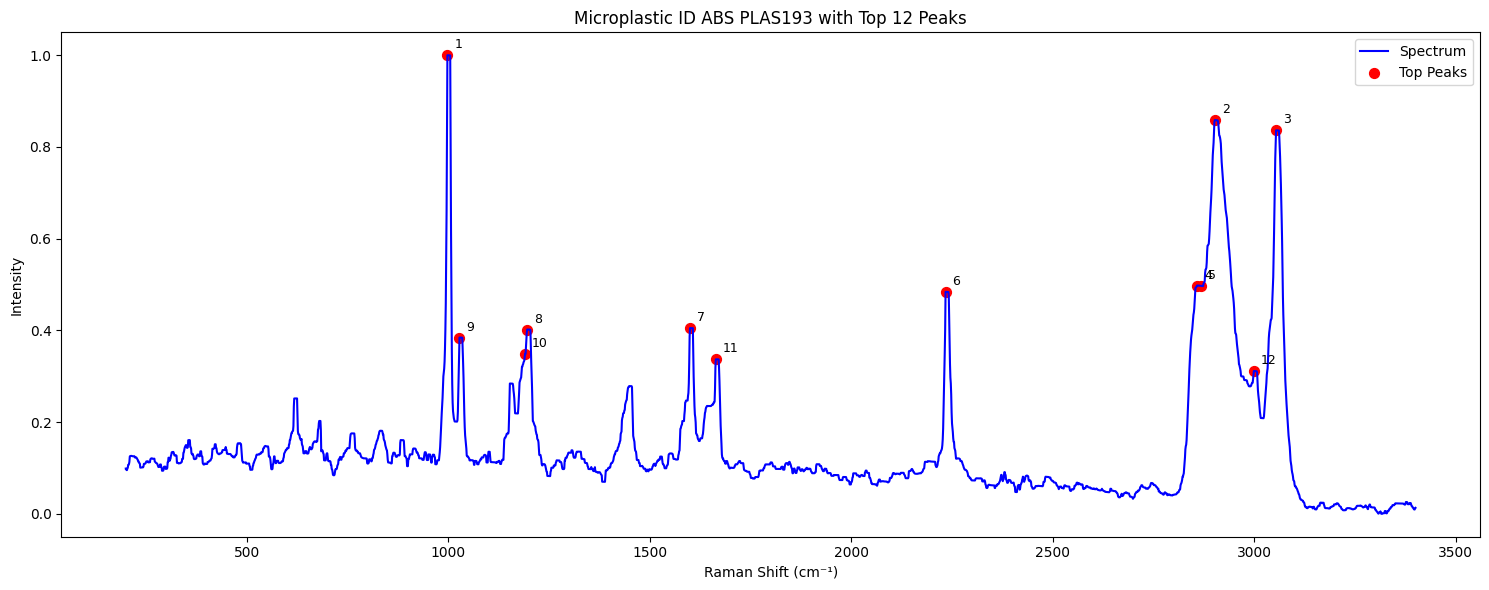


Top 12 peaks for Microplastic ID ABS PLAS193:


,peak_rank,wavenumber,intensity
0,1,998.00,1.00
1,2,"2,902.00",0.86
2,3,"3,054.00",0.84
3,4,"2,859.00",0.50
4,5,"2,867.00",0.50
...,...,...,...
7,8,"1,196.00",0.40
8,9,"1,028.00",0.38
9,10,"1,191.00",0.35
10,11,"1,664.00",0.34


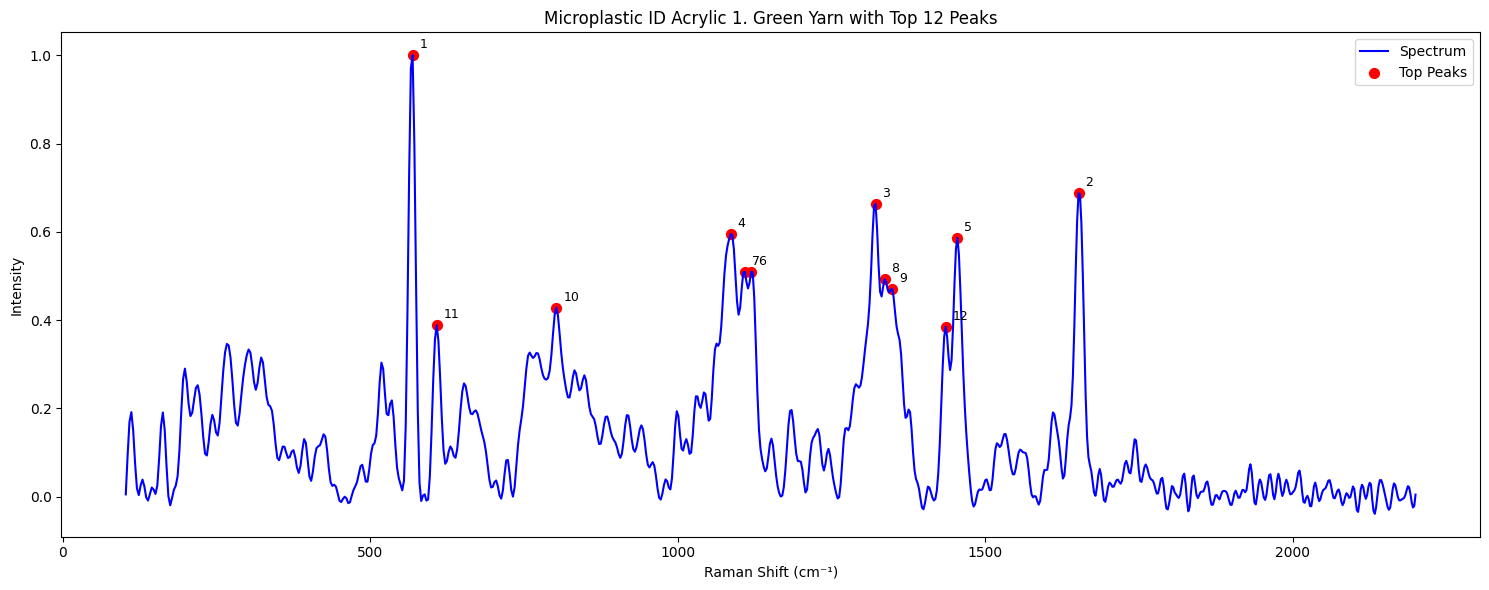


Top 12 peaks for Microplastic ID Acrylic 1. Green Yarn:


,peak_rank,wavenumber,intensity
0,1,569.01,1.00
1,2,"1,652.00",0.69
2,3,"1,321.88",0.66
3,4,"1,086.35",0.59
4,5,"1,455.02",0.59
...,...,...,...
7,8,"1,336.57",0.49
8,9,"1,348.78",0.47
9,10,802.67,0.43
10,11,608.15,0.39


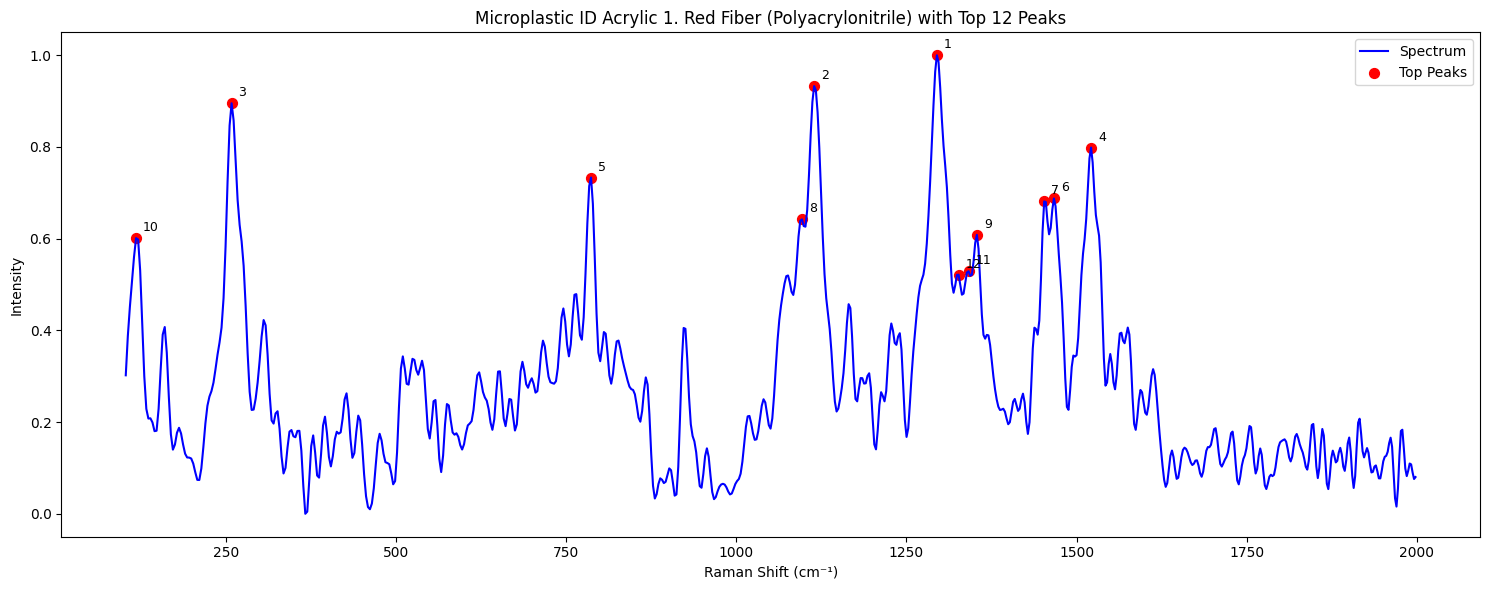


Top 12 peaks for Microplastic ID Acrylic 1. Red Fiber (Polyacrylonitrile):


,peak_rank,wavenumber,intensity
0,1,"1,294.68",1.00
1,2,"1,114.28",0.93
2,3,257.94,0.90
3,4,"1,521.36",0.80
4,5,786.32,0.73
...,...,...,...
7,8,"1,096.42",0.64
8,9,"1,353.49",0.61
9,10,117.50,0.60
10,11,"1,341.29",0.53


In [32]:
# Visualize the peak data for a sample of microplastics
if 'reference_peaks' in [table[0] for table in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
                              .fetchall()]:
    # Get a list of unique microplastic IDs that have peaks
    query = "SELECT DISTINCT microplastic_id FROM reference_peaks ORDER BY microplastic_id LIMIT 3"
    sample_ids = pd.read_sql_query(query, conn)['microplastic_id'].tolist()
    
    for mp_id in sample_ids:
        try:
            # Get the spectrum for this ID
            if isinstance(mp_id, (int, float)):
                query = f"SELECT * FROM {microplastics_table} WHERE {id_col} = {mp_id}"
            else:
                query = f"SELECT * FROM {microplastics_table} WHERE {id_col} = '{mp_id}'"
            spectrum = pd.read_sql_query(query, conn)
            
            # Get the peaks for this ID
            if isinstance(mp_id, (int, float)):
                query = f"SELECT * FROM reference_peaks WHERE microplastic_id = {mp_id} ORDER BY peak_rank"
            else:
                query = f"SELECT * FROM reference_peaks WHERE microplastic_id = '{mp_id}' ORDER BY peak_rank"
            peaks = pd.read_sql_query(query, conn)
            
            # Plot the spectrum and the identified peaks
            plt.figure(figsize=(15, 6))
            plt.plot(spectrum[raman_col], spectrum[intensity_col], 'b-', label='Spectrum')
            plt.scatter(peaks['wavenumber'], peaks['intensity'], color='red', s=50, label='Top Peaks')
            
            # Add peak labels
            for i, (idx, peak) in enumerate(peaks.iterrows()):
                plt.annotate(f"{i+1}", 
                            (peak['wavenumber'], peak['intensity']),
                            xytext=(5, 5),
                            textcoords='offset points',
                            fontsize=9)
                
            plt.title(f"Microplastic ID {mp_id} with Top 12 Peaks")
            plt.xlabel('Raman Shift (cm⁻¹)')
            plt.ylabel('Intensity')
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Display the peak data in a table
            print(f"\nTop 12 peaks for Microplastic ID {mp_id}:")
            display(peaks[['peak_rank', 'wavenumber', 'intensity']])
        except Exception as e:
            print(f"Error visualizing peaks for ID {mp_id}: {e}")
else:
    print("The reference_peaks table couldn't be found. Make sure the table was created successfully.")

### Querying the Reference Peaks Table

Now that we have created the `reference_peaks` table, we can use SQL queries to extract useful information:

Number of peaks per microplastic:


,microplastic_id,peak_count
0,myofibrillar protein BIOL015,12
1,myofibrillar protein BIOL013,12
2,keratin BIOL010,12
3,chitin BIOL022,12
4,chitin BIOL012,12
5,charcoal BIOL002,12
6,cellulose PLAS257,12
7,cellulose BIOL021,12
8,cellulose BIOL005,12
9,bone BIOL009,12



Most common peak wavenumber ranges:


,wavenumber_range,frequency
0,"2,880.00",104
1,"2,920.00",73
2,"2,850.00",64
3,"1,440.00",61
4,"1,290.00",60
5,"1,340.00",57
6,"1,610.00",52
7,"1,450.00",52
8,"1,460.00",51
9,"2,900.00",49


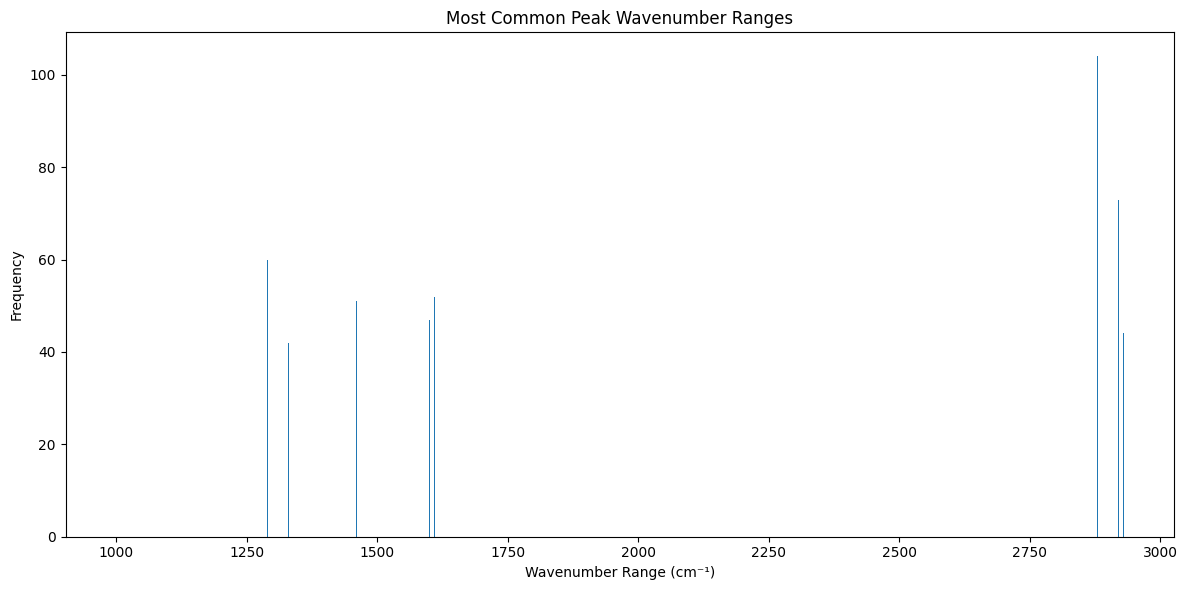

In [33]:
# Example queries for the reference_peaks table

# 1. Get all peaks for a specific microplastic ID
def get_peaks_for_id(microplastic_id):
    # Handle string IDs properly with quotes
    if isinstance(microplastic_id, (int, float)):
        query = f"""
        SELECT * FROM reference_peaks 
        WHERE microplastic_id = {microplastic_id}
        ORDER BY peak_rank
        """
    else:
        query = f"""
        SELECT * FROM reference_peaks 
        WHERE microplastic_id = '{microplastic_id}'
        ORDER BY peak_rank
        """
    return pd.read_sql_query(query, conn)

# 2. Find microplastics with similar peak patterns
def find_similar_microplastics(microplastic_id, tolerance=10):
    # Get the peaks for the reference microplastic
    reference_peaks = get_peaks_for_id(microplastic_id)
    
    similar_ids = set()
    for _, peak in reference_peaks.iterrows():
        # Look for other microplastics with peaks at similar wavenumbers
        if isinstance(microplastic_id, (int, float)):
            query = f"""
            SELECT DISTINCT microplastic_id 
            FROM reference_peaks
            WHERE microplastic_id != {microplastic_id}
            AND wavenumber BETWEEN {peak['wavenumber'] - tolerance} AND {peak['wavenumber'] + tolerance}
            """
        else:
            query = f"""
            SELECT DISTINCT microplastic_id 
            FROM reference_peaks
            WHERE microplastic_id != '{microplastic_id}'
            AND wavenumber BETWEEN {peak['wavenumber'] - tolerance} AND {peak['wavenumber'] + tolerance}
            """
        matches = pd.read_sql_query(query, conn)['microplastic_id'].tolist()
        similar_ids.update(matches)
    
    return sorted(list(similar_ids))

# 3. Count how many peaks each microplastic has in the reference_peaks table
query = """
SELECT microplastic_id, COUNT(*) as peak_count
FROM reference_peaks
GROUP BY microplastic_id
ORDER BY peak_count DESC
"""
peak_counts = pd.read_sql_query(query, conn)
print("Number of peaks per microplastic:")
display(peak_counts.head(10))

# 4. Find the most common peak wavenumbers across all microplastics
query = """
SELECT ROUND(wavenumber / 10) * 10 as wavenumber_range, 
       COUNT(*) as frequency
FROM reference_peaks
GROUP BY wavenumber_range
ORDER BY frequency DESC
"""
common_peaks = pd.read_sql_query(query, conn)
print("\nMost common peak wavenumber ranges:")
display(common_peaks.head(10))

# 5. Visualize the distribution of peak wavenumbers
plt.figure(figsize=(12, 6))
plt.bar(common_peaks['wavenumber_range'][:15], common_peaks['frequency'][:15])
plt.title('Most Common Peak Wavenumber Ranges')
plt.xlabel('Wavenumber Range (cm⁻¹)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [34]:
# Close the database connection
conn.close()
print("Database connection closed.")

Database connection closed.
